# **Apprendre à un taxi (Smartcab : taxi intelligent) à prendre et à déposer des passagers aux bons endroits : agents réflexes fondés sur les modèles**

# **1) Modelisation**

## **1.1) Le processus d'apprentissage par renforcement**

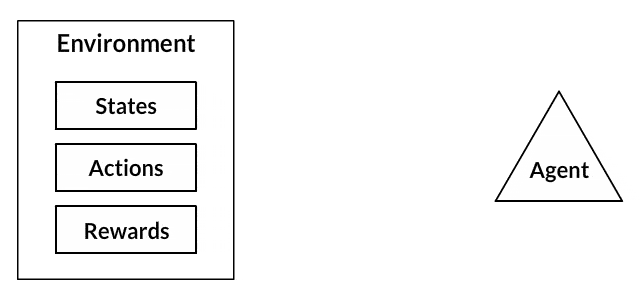

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

$$a_t = argmax_{a_i} Q(s_t, a_i)$$
$$rewards = Q(s_t, a_t)$$
$$s_{t+1} = \pi (s_t, a_t)$$

D'une certaine manière, l'**apprentissage par renforcement** est la science qui consiste à prendre des décisions optimales en utilisant des expériences. En résumé, le processus d'apprentissage par renforcement comprend ces étapes simples:

* Observation de l'environnement
* Décider comment agir en utilisant une stratégie
* Agir en conséquence
* Recevoir une récompense ou une pénalité
* Apprendre des expériences et affiner notre stratégie
* Itérer jusqu'à ce qu'une stratégie optimale soit trouvée

Le travail du Smartcab est de prendre le passager à un endroit et de le déposer dans un autre. Voici quelques éléments dont nous aimerions que notre Smartcab prenne soin:

* Déposez le passager au bon endroit.
* Gagnez du temps aux passagers en prenant le moins de temps possible pour déposer
* Prenez soin de la sécurité des passagers et des règles de circulation  


## **1.2) Il y a différents aspects qui doivent être pris en compte ici lors de la modélisation d'une solution RL à ce problème:**

### **(i) Récompenses**
  - L'agent devrait recevoir une récompense positive élevée pour un dépôt réussi car ce comportement est fortement souhaité
  - L'agent devrait être pénalisé s'il tente de déposer un passager au mauvais endroit
  - L'agent devrait recevoir une légère récompense négative pour ne pas se rendre à destination après chaque pas de temps. "Légèrement" négatif car nous préférerions que notre agent arrive en retard au lieu de faire de faux pas en essayant d'atteindre la destination le plus rapidement possible

### **(ii) Espace d'état : ensemble de toutes les situations possibles dans lesquelles notre taxi pourrait habiter. L'état doit contenir des informations utiles dont l'agent a besoin pour agir correctement.**
Il y a quatre (4) destinations  (endroits où nous pouvons prendre et déposer un passager: R, G, Y, B ou [(0,0), (0,4), (4,0), (4,3)] en coordonnées (ligne, col)) et cinq (4 + 1) emplacements passagers. Ainsi, notre environnement de taxi a 5 × 5 × 5 × 4 = 500 total des états possibles.

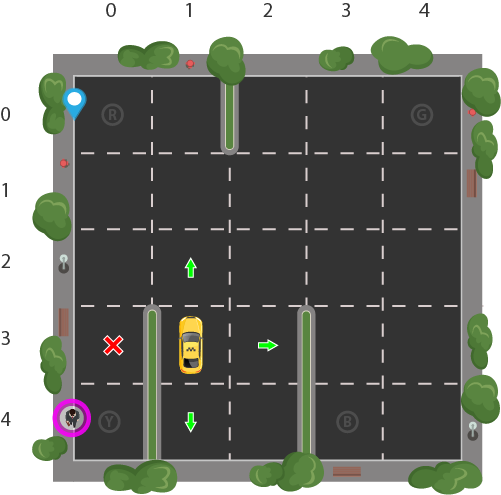

https://gym.openai.com/docs/      Taxi-v2

### **(iii) Espace d'action : ensemble de toutes les actions que notre agent peut effectuer dans un état donné**
L'agent rencontre l'un des états et il entreprend une action. L'action dans notre cas peut être de se déplacer dans une direction ou de décider de prendre/déposer un passager. En d'autres termes, nous avons six actions possibles:
* sud
* nord
* est
* ouest
* prendre un passager
* deposer un passager

Vous remarquerez dans l'illustration ci-dessus, que le taxi ne peut pas effectuer certaines actions dans certains états en raison des murs. Dans le code de l'environnement, nous fournirons simplement une pénalité de -1 pour chaque mur touché et le taxi ne se déplacera nulle part. Cela ne fera qu'accumuler des pénalités, ce qui amènera le taxi à envisager de contourner le mur.

# **2) Implementation**

## **installer gym**

In [ ]:
!pip install cmake 'gym[atari]' scipy

## **charger l'environnement de jeu et voir à quoi il ressemble**
## **Rappel**
* env.reset: Réinitialise l'environnement et renvoie un état initial aléatoire.
* env.step(action): Étape de l'environnement d'un pas de temps. Retour :
  - observation : Observations de l'environnement
  - récompense : si votre action a été bénéfique ou non
  - done : indique si nous avons récupéré et déposé un passager avec succès, également appelé un épisode
  - info : informations supplémentaires telles que les performances et la latence à des fins de débogage
* env.render: Rend une image de l'environnement (utile pour visualiser l'environnement)


In [ ]:
import gym
"""
Nous utilisons .env à la fin de makepour éviter que l'entraînement ne s'arrête à 200 itérations, 
ce qui est la valeur par défaut pour la nouvelle version de Gym
"""
env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Il y a 4 emplacements (étiquetés par des lettres différentes), et notre travail consiste à récupérer le passager à un endroit et à le déposer à un autre. Nous recevons +20 points pour un dépôt réussi et perdons 1 point pour chaque fois- Il y a aussi une pénalité de 10 points pour les actions illégales de ramassage et de dépôt. 

In [ ]:
env.reset() # Réinitialise l'environnement et renvoie un état initial aléatoire.
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


* Le carré plein en jaune représente le taxi, qui est jaune sans passager et vert avec un passager.
* Le tuyau ("|") représente un mur que le taxi ne peut pas traverser.
* R, G, Y, B sont les lieux de prise en charge et de destination possibles. La lettre bleue représente le lieu actuel de prise en charge des passagers et la lettre violette la destination actuelle.

Comme vérifié par les impressions, nous avons un espace d'action de taille 6 et un espace d'état de taille 500. Comme vous le verrez, notre algorithme RL n'aura pas besoin de plus d'informations que ces deux choses. Tout ce dont nous avons besoin est un moyen d'identifier un état de manière unique en attribuant un numéro unique à chaque état possible, et RL apprend à choisir un numéro d'action de 0 à 5 où : 
- 0 = sud
- 1 = nord
- 2 = est
- 3 = ouest
- 4 = ramassage
- 5 = depot

L'apprentissage par renforcement apprendra une cartographie des états à l' action optimale à effectuer dans cet état par exploration , c'est-à-dire que l'agent explore l'environnement et entreprend des actions basées sur des récompenses définies dans l'environnement.

L'action optimale pour chaque état est l'action qui a la récompense cumulative à long terme la plus élevée .

**Nous pouvons en fait prendre notre illustration ci-dessus, encoder son état et le donner à l'environnement pour qu'il le rende dans Gym.**  
Nous utilisons les coordonnées de notre illustration pour générer un nombre correspondant à un état compris entre 0 et 499.
Ensuite, nous pouvons définir l'état de l'environnement manuellement en `env.s` utilisant ce nombre codé. Vous pouvez jouer avec les chiffres et vous verrez le taxi, le passager et la destination se déplacer.

In [ ]:
state = env.encode(3, 1, 2, 0) # (ligne du taxi, colonne du taxi, index du passager, de la destination)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## **La table des récompenses**
Lorsque l'environnement Taxi est créé, une table de récompenses initiale est également créée, appelée «P». On peut y penser comme une matrice qui a le nombre d'états en lignes et le nombre d'actions en colonnes.

In [ ]:
env.P[328]
# {action: [(probability, nextstate, reward, done)]}

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

* Le 0-5 correspond aux actions (sud, nord, est, ouest, prise d'un passager, déposer un passager) que le taxi peut effectuer à notre état actuel dans l'illustration.
Dans cet env, probabilityvaut toujours 1.0.
* nextstate est l'état dans lequel nous serions si nous prenons l'action à cet index du dict
* Toutes les actions de mouvement ont une récompense de -1 et les actions de ramassage / dépôt ont une récompense de -10 dans cet état particulier. Si nous sommes dans un état où le taxi a un passager et est au sommet de la bonne destination, nous verrions une récompense de 20 à l'action de dépose (5)
doneest utilisé pour nous dire quand nous avons déposé avec succès un passager au bon endroit. Chaque retour réussi est la fin d'un épisode

## **Résoudre l'environnement sans apprentissage par renforcement : agent reflexe simple**
Nous allons créer une boucle infinie qui se déroule jusqu'à ce qu'un passager atteigne une destination (un épisode ), ou en d'autres termes, lorsque la récompense reçue est de 20. La méthode `env.action_space.sample()` sélectionne automatiquement une action aléatoire parmi l'ensemble de toutes les actions possibles.

In [ ]:
env.s = 328  # mettre l'environnement à l'état d'illustration (voir plus haut)

epochs = 0
penalties, reward = 0, 0

frames = [] # pour l'animation (voir la cellule suivante)

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 893
Penalties incurred: 299


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 893
State: 0
Action: 5
Reward: 20


Pas bon. Notre agent prend des milliers de pas dans le temps et fait beaucoup de mauvais dépôts pour livrer un seul passager à la bonne destination.

C'est parce que nous n'apprenons pas de l'expérience passée. Nous pouvons répéter cela encore et encore, et cela ne sera jamais optimisé. L'agent n'a aucun souvenir de l'action qui était la meilleure pour chaque état, ce qui est exactement ce que l'apprentissage par renforcement fera pour nous.


## **Entrez dans l'apprentissage par renforcement : agent reflexe basé sur les modeles**

```Playing Atari with Deep Reinforcement Learning (Volodymyr Mnih et al., 2013)```

Essentiellement, le Q-learning permet à l'agent d'utiliser les récompenses de l'environnement pour apprendre, au fil du temps, la meilleure action à entreprendre dans un état donné. Une valeur Q pour une combinaison état-action particulière est représentative de la "qualité" d'une action prise à partir de cet état. De meilleures valeurs Q impliquent de meilleures chances d'obtenir de plus grandes récompenses.

* Initialisez la table Q par tous les zéros.
* Commencez à explorer les actions: pour chaque état, sélectionnez l'une des actions possibles pour l'état actuel (S).
* Passez à l'état suivant (S') suite à cette action (a) : $s_{t+1} = \pi (s_t, a_t)$
* Pour toutes les actions possibles de l'état (S'), sélectionnez celle avec la valeur Q la plus élevée : $a_t = argmax_{a_i} Q(s_t, a_i)$
* Mettez à jour les valeurs de la table Q à l'aide de l'équation : $Q(s_t, a_t) = (1-\alpha) Q(s_t, a_t) + \alpha (r + \gamma max_{a_i} Q(s_{t+1},a_i))$
    - $\alpha$  (alpha) est le taux d'apprentissage ($0 < \alpha \leq 1$) : la mesure dans laquelle nos valeurs Q sont mises à jour à chaque itération.
    - $\gamma$  (gamma) est le facteur d'actualisation ($0 \leq \gamma \leq 1$): détermine l'importance que nous voulons accorder aux récompenses futures. Une valeur élevée pour le facteur de remise (proche de 1 ) capture l'attribution effective à long terme, alors qu'un facteur de remise de 0 fait que notre agent ne considère que la récompense immédiate, ce qui le rend gourmand.
    - La valeur apprise $\alpha (r + \gamma max_{a_i} Q(s_{t+1},a_i))$ est une combinaison de la récompense pour avoir effectué l'action en cours dans l'état actuel et de la récompense maximale escomptée de l'état suivant dans lequel nous serons une fois que nous aurons pris l'action en cours.
* Définissez l'état suivant comme état actuel.
* Si l'état de l'objectif est atteint, terminez et répétez le processus.

### **Table Q**
Le Q-table est une matrice où nous avons une ligne pour chaque état (500) et une colonne pour chaque action (6). Il est d'abord initialisé à 0, puis les valeurs sont mises à jour après l'entraînement. Notez que la Q-table a les mêmes dimensions que la table de récompense, mais qu'elle a un but complètement différent.
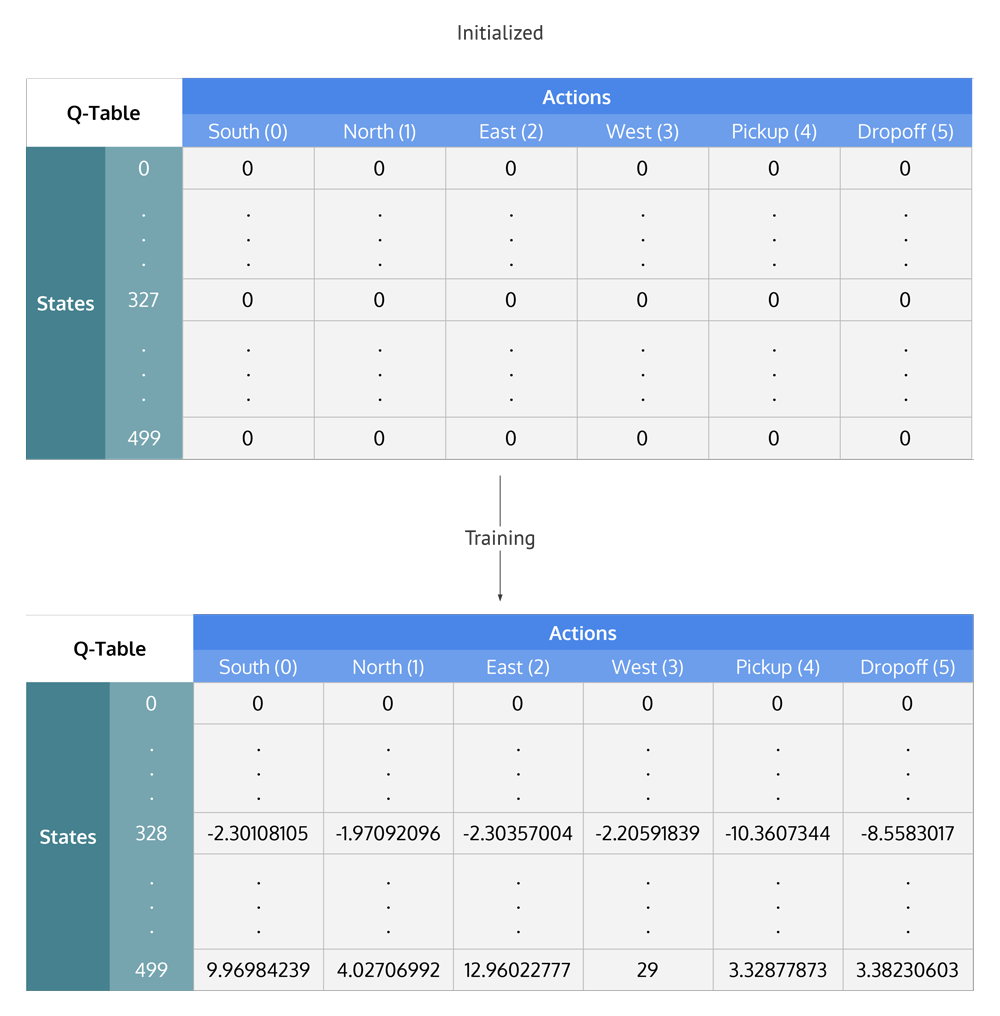

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Après une exploration suffisamment aléatoire des actions, les valeurs Q ont tendance à converger en servant notre agent en tant que fonction valeur-action qu'il peut exploiter pour choisir l'action la plus optimale dans un état donné.

Il y a un compromis entre l'exploration (choisir une action aléatoire) et l'exploitation (choisir des actions basées sur des valeurs Q déjà apprises). Nous voulons empêcher l'action de toujours suivre la même route, et peut-être surajustement, nous allons donc introduire un autre paramètre appelé $\epsilon$ "epsilon" pour y répondre pendant la formation.

Au lieu de simplement sélectionner la meilleure action de valeur Q apprise, nous préférerons parfois explorer davantage l'espace d'action. Une valeur epsilon inférieure entraîne des épisodes avec plus de pénalités (en moyenne), ce qui est évident car nous explorons et prenons des décisions aléatoires.

Nous pouvons maintenant créer l'algorithme d'entraînement qui mettra à jour cette Q-table au fur et à mesure que l'agent explore l'environnement sur des milliers d'épisodes.

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

n_episodes = 100000
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, n_episodes + 1):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        """
        Nous décidons de choisir une action aléatoire ou d'exploiter les valeurs Q déjà calculées. 
        Cela se fait simplement en utilisant la epsilon-valeur et en la comparant à la random.uniform(0, 1) fonction, 
        qui renvoie un nombre arbitraire entre 0 et 1.
        """
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        # Nous exécutons l'action choisie dans l'environnement pour obtenir le next_state et le reward de l'exécution de l'action.
        next_state, reward, done, info = env.step(action) 
        
        # Après cela, nous calculons la valeur Q maximale pour les actions correspondant à next_state,
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # et avec cela, nous pouvons facilement mettre à jour notre valeur Q en new_q_value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 1min 11s, sys: 20.3 s, total: 1min 31s
Wall time: 1min 11s


In [ ]:
q_table[328]

array([ -2.41209897,  -2.27325184,  -2.40563866,  -2.3510046 ,
       -10.94229952, -11.07017693])

**La valeur Q maximale est "nord" xxxxx, il semble donc que Q-learning ait effectivement appris la meilleure action à entreprendre dans l'état de notre illustration!**

### **Évaluons les performances de notre agent.**
Nous n'avons pas besoin d'explorer davantage les actions, donc maintenant l'action suivante est toujours sélectionnée en utilisant la meilleure valeur Q:



In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
frames_RL = []

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        frames_RL.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.83
Average penalties per episode: 0.0


In [ ]:
print_frames(frames_RL)

Streaming output truncated to the last 5000 lines.
|Y| : |B: |
+---------+
  (West)

Timestep: 899
State: 101
Action: 3
Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 900
State: 1
Action: 1
Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 901
State: 17
Action: 4
Reward: -1
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 902
State: 117
Action: 0
Reward: -1
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 903
State: 217
Action: 0
Reward: -1
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 904
State: 237
Action: 2
Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 905
State: 257
Action: 2
Reward: -1
+---------+
|R: | : :G|
| :

Nous pouvons voir à partir de l'évaluation que les performances de l'agent se sont considérablement améliorées et qu'il n'a encouru aucune pénalité, ce qui signifie qu'il a effectué les bonnes actions de ramassage / dépôt avec 100 passagers différents.

# **3) Hyperparamètres et optimisations**
Les valeurs de `alpha`,` gamma` et `epsilon` étaient principalement basées sur l'intuition et certains" hit and trial ", mais il existe de meilleures façons de trouver de bonnes valeurs.

Idéalement, les trois devraient diminuer au fil du temps, car à mesure que l'agent continue à apprendre, il construit en fait des a priori plus résilients;

* $\alpha$ (le taux d'apprentissage) devrait diminuer à mesure que vous continuez à acquérir une base de connaissances de plus en plus étendue.
* $\gamma$ : à mesure que vous vous rapprochez de la date limite, votre préférence pour la récompense à court terme devrait augmenter, car vous ne serez pas là assez longtemps pour obtenir la récompense à long terme, ce qui signifie que votre gamma devrait diminuer.
* $\epsilon$ : à mesure que nous développons notre stratégie, nous avons moins besoin d'exploration et plus d'exploitation pour obtenir plus d'utilité de notre politique, donc à mesure que les essais augmentent, epsilon devrait diminuer.

# **Références :**

* https://gym.openai.com/
* https://www.coursera.org/learn/practical-rl?ranMID=40328&ranEAID=OyHlmBp2G0c&ranSiteID=OyHlmBp2G0c-JdjEQNhkWep7m.HfuOHODg&siteID=OyHlmBp2G0c-JdjEQNhkWep7m.HfuOHODg&utm_content=10&utm_medium=partners&utm_source=linkshare&utm_campaign=OyHlmBp2G0c
* https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/